***(i) Import the function from the module "mzprojection"***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mzprojection import mzprojection_multivariate, split_long_time_series, calc_correlation

help(mzprojection_multivariate)

Help on function mzprojection_multivariate in module mzprojection:

mzprojection_multivariate(delta_t, u, dudt0, f, flag_terms=False, flag_debug=False)
    Evaluate projection of f(t) on u(t),
      f_i(t) = Omega_ij*u_j(t) - int_0^t Gamma_ij(s)*u_j(t-s) ds + r_i(t)
    taking summation over the repeated index j.
    
    Parameters
    ----------
    delta_t : float
        Time step size
    u[nsample,nperiod,nu] : Numpy array (float64 or complex128)
        Explanatory variable u_j(t).
        nsample is the number of samples.
        nperiod is the number of time steps of a short-time data.
        nu is the number of independent explanatory variable (j=0,1,...,nu-1).
    dudt0[nsample,nu] : Numpy array (float64 or complex128)
        = du/dt(t=0)
    f[nsample,nperiod,nf] : Numpy array (float64 or complex128)
        Response variable f_i(t).
        nf is the number of independent response variables (i=0,1,...,nf-1).
        If 2D array f[nsample,nperiod] is passed, it is treated

***(ii) Prepare ensemble of time series data***  
Here, we split a long time-series data of statistically steady state into a number of samples of short-time data.

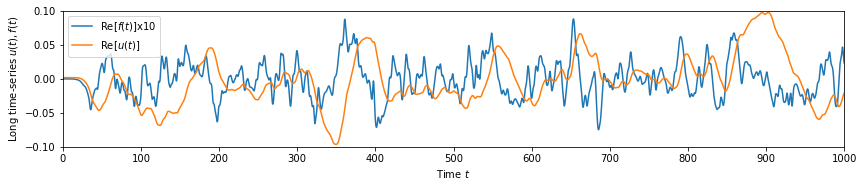

In [2]:
#= Read sample data =
indata = np.loadtxt('../sample_data/sample_time_series.dat')
t_raw     = indata[:,0]                     # Time t
u_raw    = indata[:,1] + 1.0j * indata[:,2] # Variable of interest u(t)
dudt_raw = indata[:,3] + 1.0j * indata[:,4] # = du/dt
f_raw    = indata[:,5] + 1.0j * indata[:,6] # Analyzed data f(t)

fig = plt.figure(figsize=(14,2.5))
ax = fig.add_subplot(111)
ax.set_xlim(0,1000)
ax.set_xticks(np.arange(0,1001,100))
ax.set_ylim(-0.1,0.1)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Long time-series $u(t), f(t)$")
ax.plot(t_raw,f_raw.real*10,label="Re[$f(t)$]x10")
ax.plot(t_raw,u_raw.real,label="Re[$u(t)$]")
plt.legend()
plt.show()

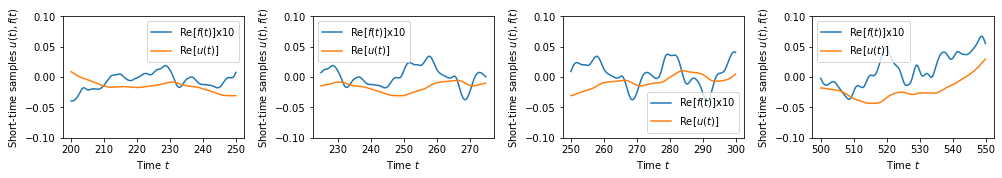

In [3]:
#= Split a long time series data into samples of short-time data =
ista    = 2000                # Start time step number for sampling   
nperiod = 500                 # Time step length of a short-time sample                 
nshift  = 1                   # Length of time shift while sampling
t   =split_long_time_series(t_raw,ista=ista,nperiod=nperiod,nshift=nshift)
u   =split_long_time_series(u_raw,ista=ista,nperiod=nperiod,nshift=nshift)
dudt=split_long_time_series(dudt_raw,ista=ista,nperiod=nperiod,nshift=nshift)
f   =split_long_time_series(f_raw,ista=ista,nperiod=nperiod,nshift=nshift)
dudt0 = dudt[:,0] # dudt0[nsample], dudt[nsample,nperiod] 

fig = plt.figure(figsize=(14,2.5))
samples = [0,250,500,3000]
for i in range(len(samples)):
    ax = fig.add_subplot(int("14{:}".format(i+1)))
    isample = samples[i]
    ax.set_ylim(-0.1,0.1)
    ax.set_xlabel("Time $t$")
    ax.set_ylabel("Short-time samples $u(t), f(t)$")
    ax.plot(t[isample,:],f[isample,:].real*10,label="Re[$f(t)$]x10")
    ax.plot(t[isample,:],u[isample,:].real,label="Re[$u(t)$]")
    ax.legend()
fig.tight_layout()
plt.show()

***(iii) Apply the Moti-Zwanzig projection operator method***  
The projection of $f(t)$ on $u(t)$ is calculated as,  
    $f(t)=\Omega u(t)+s(t)+r(t)$,  
    $s(t)=-\int_0^t \Gamma(t) u(t-v)dv$.  
The Markov coefficient $\Omega$, the memory function $\Gamma(t)$ and the uncorrelated term $r(t)$ are obtained as outputs.  
(Some correlations, e.g., $\langle r(t) u \rangle$ are also obtained to check the result.)

In [4]:
delta_t = t_raw[1] - t_raw[0] # Time step size
omega, memoryf, s, r = mzprojection_multivariate(delta_t, u, dudt0, f, flag_terms=True, flag_debug=True)
t_cor = delta_t * np.arange(memoryf.shape[0])

### Reshape for single variable
omega = omega.reshape(1)
memoryf = memoryf.reshape(nperiod)
s = s.reshape(s.shape[0],nperiod)
r = r.reshape(s.shape[0],nperiod)

nsample= 7502 , nperiod= 500 , nu= 1 , nf= 1
# Elapsed time to prepare correlations [sec]: 0.0053331851959228516
      uu0_inv[nu,nu].shape= (1, 1) complex128
ududt[nperiod,nu,nu].shape= (500, 1, 1) complex128
    G[nperiod,nu,nu].shape= (500, 1, 1) complex128
      wG0_inv[nu,nu].shape= (1, 1) complex128
# Elapsed time to calc. omega & memoryf [sec]: 0.021506786346435547
          omega[nf,nu].shape= (1, 1) complex128
memoryf[nperiod,nf,nu].shape= (500, 1, 1) complex128
# Elapsed time to calc. residual r [sec]: 0.28128719329833984
s[nsample,nperiod,nf].shape= (7502, 500, 1) complex128
r[nsample,nperiod,nf].shape= (7502, 500, 1) complex128


***(iv-a) Check results: plot $\Omega$ and $\Gamma(t)$***  

Markov coefficient Omega =  [-0.00036439+0.00257615j]


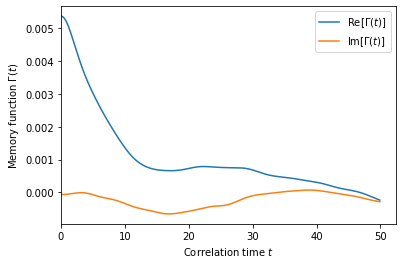

In [5]:
print("Markov coefficient Omega = ", omega)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Correlation time $t$")
ax.set_ylabel("Memory function $\Gamma(t)$")
ax.plot(t_cor,memoryf.real,label="Re[$\Gamma(t)$]")
ax.plot(t_cor,memoryf.imag,label="Im[$\Gamma(t)$]")
ax.set_xlim(0,None)
plt.legend()
plt.show()

***(iv-b) Check results: plot time evolution of $f(t)=\Omega u(t)+s(t)+r(t)$***  

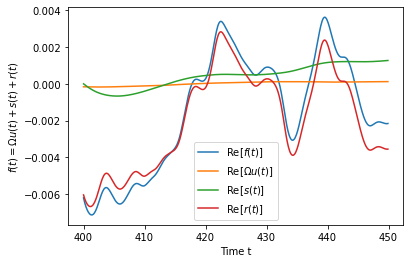

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Time t")
ax.set_ylabel("$f(t)=\Omega u(t)+s(t)+r(t)$")
isample=2000
ax.plot(t[isample,:],f[isample,:].real,label="Re[$f(t)$]")
ax.plot(t[isample,:],(omega*u[isample,:]).real,label="Re[$\Omega u(t)$]")
ax.plot(t[isample,:],s[isample,:].real,label="Re[$s(t)$]")
ax.plot(t[isample,:],r[isample,:].real,label="Re[$r(t)$]")
plt.legend()
plt.show()

***(iv-c) Check results: Extended generalized fluctuation-dissipation theorem $\Gamma(t) = \langle r(t) du^*/dt \rangle \cdot \langle u u^* \rangle^{-1}$***  

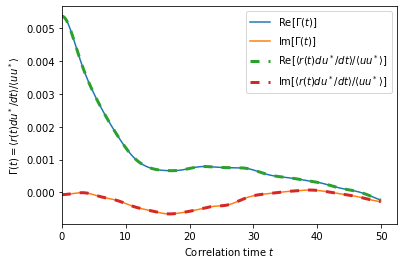

In [7]:
u0 = u[:,0]
f0 = f[:,0]
r0 = r[:,0]
uu = calc_correlation(u,u0)
fu = calc_correlation(f,u0)
rdudt = calc_correlation(r,dudt0)
ru = calc_correlation(r,u0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Correlation time $t$")
ax.set_ylabel(r"$\Gamma(t) = \langle r(t) du^*/dt \rangle / \langle u u^* \rangle$")
ax.plot(t_cor,memoryf.real,label="Re[$\Gamma(t)$]")
ax.plot(t_cor,memoryf.imag,label="Im[$\Gamma(t)$]")
ax.plot(t_cor,(rdudt/uu[0]).real,label=r"Re[$\langle r(t) du^*/dt \rangle / \langle u u^* \rangle$]",dashes=[3,3],linewidth=3)
ax.plot(t_cor,(rdudt/uu[0]).imag,label=r"Im[$\langle r(t) du^*/dt \rangle / \langle u u^* \rangle$]",dashes=[3,3],linewidth=3)
ax.set_xlim(0,None)
plt.legend()
plt.show()

***(iv-d) Check results: $\langle r(t) u^* \rangle = 0$***  
Namely, the uncorrelated term $r(t)$ indeed extracts the part of $f(t)$ uncorrelated with $u$. It is checked by $\langle r(t) u^* \rangle \ll \langle f(t) u^* \rangle$.

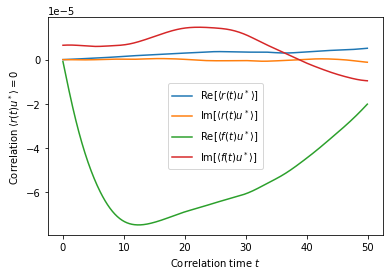

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Correlation time $t$")
ax.set_ylabel(r"Correlation $\langle r(t) u^* \rangle = 0$")
ax.plot(t_cor,ru.real,label=r"Re[$\langle r(t) u^* \rangle$]")
ax.plot(t_cor,ru.imag,label=r"Im[$\langle r(t) u^* \rangle$]")
ax.plot(t_cor,fu.real,label=r"Re[$\langle f(t) u^* \rangle$]")
ax.plot(t_cor,fu.imag,label=r"Im[$\langle f(t) u^* \rangle$]")
plt.legend()
plt.show()

***(v-a) Fitting the memory function $\Gamma(t)$***
$$
\Gamma(t) = \frac{\gamma}{\tau} \exp\left(-\frac{t}{\tau}\right)
$$
where $\gamma, \tau \in \mathbb{C}$.

gamma= (0.044298167892645915-0.009481579556680067j)
tau= (7.90385586982981-2.243877940911494j)


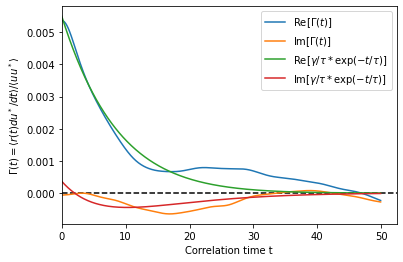

In [9]:
from mzprojection import memoryf_get_fitting_coef, memoryf_fitted
tau, cl = memoryf_get_fitting_coef(delta_t,memoryf,order=0,t_range=int(len(memoryf)/2))
gamma = cl[0]*tau
print("gamma=",gamma)
print("tau=",tau)

t_cor = delta_t*np.arange(len(memoryf))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Correlation time t")
ax.set_ylabel(r"$\Gamma(t) = \langle r(t) du^*/dt \rangle / \langle u u^* \rangle$")
ax.axhline(0,color="k",ls="dashed")
ax.plot(t_cor,memoryf.real,label=r"Re[$\Gamma(t)$]")
ax.plot(t_cor,memoryf.imag,label=r"Im[$\Gamma(t)$]")
ax.plot(t_cor,memoryf_fitted(tau,cl,t_cor).real,label=r"Re[$\gamma/\tau*\exp(-t/\tau)$]")
ax.plot(t_cor,memoryf_fitted(tau,cl,t_cor).imag,label=r"Im[$\gamma/\tau*\exp(-t/\tau)$]")
# ax.plot(t_cor,(gamma/tau*np.exp(-t_cor/tau)).real,label=r"Re[$\gamma/\tau*\exp(-t/\tau)$]")
# ax.plot(t_cor,(gamma/tau*np.exp(-t_cor/tau)).imag,label=r"Im[$\gamma/\tau*\exp(-t/\tau)$]")
ax.set_xlim(0,None)
plt.legend()
plt.show()

***(v-b) Fitting the uncorrelated term $\langle r(t) r \rangle$***
$$
\langle r(t) r \rangle = \mathrm{Re} \left[\frac{\sigma^2}{\theta}\right] \exp\left(-\frac{t}{\theta}\right)
$$
where $\sigma \in \mathbb{R}$ and $\theta \in \mathbb{C}$.

In [10]:
from mzprojection import rr_get_fitting_coef, rr_fitted
theta, sigma = rr_get_fitting_coef(delta_t,rr,t_range=int(len(rr)/2))
print("sigma=",sigma)
print("theta=",theta)

t_cor = delta_t*np.arange(len(rr))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Correlation time t")
ax.set_ylabel(r"$\Gamma(t) = \langle r(t) du^*/dt \rangle / \langle u u^* \rangle$")
ax.axhline(0,color="k",ls="dashed")
ax.plot(t_cor,rr.real,label=r"Re[$\langle r(t)r^* \rangle$]")
ax.plot(t_cor,rr.imag,label=r"Im[$\langle r(t)r^* \rangle$]")
ax.plot(t_cor,rr_fitted(theta,sigma,t_cor).real,label=r"Re[$\sigma^2/\theta*\exp(-t/\theta)$]")
ax.plot(t_cor,rr_fitted(theta,sigma,t_cor).imag,label=r"Im[$\sigma^2/\theta*\exp(-t/\theta)$]")
# ax.plot(t_cor,((sigma**2/theta).real*np.exp(-t_cor/theta)).real,label=r"Re[$\sigma^2/\theta*\exp(-t/\theta)$]")
# ax.plot(t_cor,((sigma**2/theta).real*np.exp(-t_cor/theta)).imag,label=r"Im[$\sigma^2/\theta*\exp(-t/\theta)$]")
ax.set_xlim(0,None)
plt.legend()
plt.show()

NameError: name 'rr' is not defined

In [ ]:
print("Omega=",omega)
print("gamma=",gamma)
print("  tau=",tau)
print("sigma=",sigma)
print("theta=",theta)